# Overview

In this notebook, we conduct data cleaning of the merged table. 

**Author**: Oscar Javier Bastidas Jossa. 

**Email**: oscar.jossa@deusto.es.

In [62]:
import pandas as pd
import numpy as np
from utilities import Data_cleaning

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from plotly.express.colors import sample_colorscale

import math
import copy
import re
%matplotlib inline

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [66]:
# Read data and assign the index

df = pd.read_hdf('../data/cleaned_dataset_v1.h5',  key='data')
df.fillna(0, inplace=True)
df.shape

(46192, 9142)

# Datacleaning and preprocessing


The data cleaning performed in the current session involves eliminating columns where all values are zero, as well as removing the initial number of series calculated from the merged file. Subsequently, recalculations were done using columns from the processed table in data_merged_table.ipynb. Additionally, total reps and total time values were calculated for all exercises, as well as for individual exercises.

## Nomenclature

- **variable**: Number of series. (e.g. 1 leg bridge (left) = 10)
- **variable**\_**reps**\_**n**: Number of reps per serie . (e.g. 1 leg bridge (left)_reps_1 = 5 -> 5 reps in the serie 1)
- **variable**\_**time**\_**n**: Time in seconds per serie (e.g. 1 leg bridge (left)_time_2 = 30s -> 30s in the serie 2)
- **sum_of_reps**: Sum of all the rep values executed during the session.
- **sum_of_time**: Sum of the total time values for all the exercises during the session.
- **sum_of_reps_per_exercise**: Sum of the rep values executed during the session per exercise.
- **sum_of_time_per_exercise**: Sum of the time values during the session per exercise.
- **total_count_of_series_reps**: The count of the series for reps.
- **total_count_of_series_time**: The count of the sereis for time.


In [77]:
# Removing all columns with zero values

columns_with_zero_values = df.columns[(df == 0).all()]
df = df.drop(columns=columns_with_zero_values)
df.head(5)

,session_executions_updated_at,user_programs_user_id,1 leg bridge (left),1 leg bridge (left)_reps_1,1 leg bridge (left)_reps_10,1 leg bridge (left)_reps_11,1 leg bridge (left)_reps_12,1 leg bridge (left)_reps_13,1 leg bridge (left)_reps_14,1 leg bridge (left)_reps_15,1 leg bridge (left)_reps_16,1 leg bridge (left)_reps_17,1 leg bridge (left)_reps_2,1 leg bridge (left)_reps_3,1 leg bridge (left)_reps_4,1 leg bridge (left)_reps_5,1 leg bridge (left)_reps_6,1 leg bridge (left)_reps_7,1 leg bridge (left)_reps_8,1 leg bridge (left)_reps_9,1 leg bridge (left)_time_1,1 leg bridge (left)_time_10,1 leg bridge (left)_time_11,1 leg bridge (left)_time_12,1 leg bridge (left)_time_13,1 leg bridge (left)_time_14,1 leg bridge (left)_time_15,1 leg bridge (left)_time_16,1 leg bridge (left)_time_17,1 leg bridge (left)_time_2,1 leg bridge (left)_time_3,1 leg bridge (left)_time_4,1 leg bridge (left)_time_5,1 leg bridge (left)_time_6,1 leg bridge (left)_time_7,1 leg bridge (left)_time_8,1 leg bridge (left)_time_9,1 leg bridge (right),1 leg bridge (right)_reps_1,1 leg bridge (right)_reps_10,1 leg bridge (right)_reps_11,1 leg bridge (right)_reps_12,1 leg bridge (right)_reps_13,1 leg bridge (right)_reps_14,1 leg bridge (right)_reps_15,1 leg bridge (right)_reps_16,1 leg bridge (right)_reps_17,1 leg bridge (right)_reps_2,1 leg bridge (right)_reps_3,1 leg bridge (right)_reps_4,1 leg bridge (right)_reps_5,1 leg bridge (right)_reps_6,1 leg bridge (right)_reps_7,1 leg bridge (right)_reps_8,1 leg bridge (right)_reps_9,1 leg bridge (right)_time_1,1 leg bridge (right)_time_10,1 leg bridge (right)_time_11,1 leg bridge (right)_time_12,1 leg bridge (right)_time_13,1 leg bridge (right)_time_14,1 leg bridge (right)_time_15,1 leg bridge (right)_time_16,1 leg bridge (right)_time_17,1 leg bridge (right)_time_2,1 leg bridge (right)_time_3,1 leg bridge (right)_time_4,1 leg bridge (right)_time_5,1 leg bridge (right)_time_6,1 leg bridge (right)_time_7,1 leg bridge (right)_time_8,1 leg bridge (right)_time_9,1 leg dead lift (left),1 leg dead lift (left)_reps_1,1 leg dead lift (left)_reps_10,1 leg dead lift (left)_reps_11,1 leg dead lift (left)_reps_12,1 leg dead lift (left)_reps_13,1 leg dead lift (left)_reps_14,1 leg dead lift (left)_reps_15,1 leg dead lift (left)_reps_2,1 leg dead lift (left)_reps_3,1 leg dead lift (left)_reps_4,1 leg dead lift (left)_reps_5,1 leg dead lift (left)_reps_6,1 leg dead lift (left)_reps_7,1 leg dead lift (left)_reps_8,1 leg dead lift (left)_reps_9,1 leg dead lift (left)_time_1,1 leg dead lift (left)_time_10,1 leg dead lift (left)_time_11,1 leg dead lift (left)_time_12,1 leg dead lift (left)_time_13,1 leg dead lift (left)_time_14,1 leg dead lift (left)_time_15,1 leg dead lift (left)_time_2,1 leg dead lift (left)_time_3,1 leg dead lift (left)_time_4,1 leg dead lift (left)_time_5,1 leg dead lift (left)_time_6,1 leg dead lift (left)_time_7,1 leg dead lift (left)_time_8,1 leg dead lift (left)_time_9,1 leg dead lift (right),1 leg dead lift (right)_reps_1,1 leg dead lift (right)_reps_10,1 leg dead lift (right)_reps_11,1 leg dead lift (right)_reps_12,1 leg dead lift (right)_reps_13,1 leg dead lift (right)_reps_14,1 leg dead lift (right)_reps_15,1 leg dead lift (right)_reps_2,1 leg dead lift (right)_reps_3,1 leg dead lift (right)_reps_4,1 leg dead lift (right)_reps_5,1 leg dead lift (right)_reps_6,1 leg dead lift (right)_reps_7,1 leg dead lift (right)_reps_8,1 leg dead lift (right)_reps_9,1 leg dead lift (right)_time_1,1 leg dead lift (right)_time_10,1 leg dead lift (right)_time_11,1 leg dead lift (right)_time_12,1 leg dead lift (right)_time_13,1 leg dead lift (right)_time_14,1 leg dead lift (right)_time_15,1 leg dead lift (right)_time_2,1 leg dead lift (right)_time_3,1 leg dead lift (right)_time_4,1 leg dead lift (right)_time_5,1 leg dead lift (right)_time_6,1 leg dead lift (right)_time_7,1 leg dead lift (right)_time_8,1 leg dead lift (right)_time_9,1 leg dead lift 1with KB (right),1 leg dead lift 1with KB (right)_reps_1,1 leg dead lift 1with KB (righ

In [79]:
# Removing the Initial columns that containt the total number of series 

columns_without_reps_and_time = df.columns[~((df.columns.str.contains("_reps_")) |
                                             (df.columns.str.contains("_time_")) |      
                                             (df.columns.str.contains("session_executions_updated_at")) |
                                             (df.columns.str.contains("user_programs_user_id")) |
                                             (df.columns.str.contains("date")) |                                             
                                             (df.columns.str.contains("session_executions_summary_total_kcal")) |
                                             (df.columns.str.contains("session_executions_summary_effort")) |
                                             (df.columns.str.contains("session_executions_summary_points")) |
                                             (df.columns.str.contains("session_executions_summary_value_of_session")) )]

df = df.drop(columns=columns_without_reps_and_time)
df.shape

(46192, 6909)

In [80]:
# Drop columns to only itereate over the exercises

df_exercises = df.drop(columns=['session_executions_updated_at', 
                                'user_programs_user_id', 
                                'session_executions_summary_effort',
                                'session_executions_summary_points',
                                'session_executions_summary_total_kcal',
                                'session_executions_summary_value_of_session',
                                'date'])

In [144]:
def add_count_and_sum_columns(df):
    """
    Add the followings columns to a DataFrame.
    sum_of_reps: Sum of all the rep values executed during the session.
    sum_of_time: Sum of the total time values for all the exercises during the session.
    sum_of_reps_per_exercise: Sum of the rep values executed during the session per exercise.
    sum_of_time_per_exercise: Sum of the time values during the session per exercise.
    total_count_of_series_reps: The count of the series for reps.
    total_count_of_series_time: The count of the sereis for time.

    Parameters:
    df (pandas.DataFrame): Input DataFrame.

    Returns:
    pandas.DataFrame: DataFrame with added columns.
    """
    count_reps_all = {}
    
    for index, row in df.iterrows():
        
        # Get the name of the columns which the values are different from zero
        series_name = row[row.astype(bool)].keys()
        
        # Initialize empty dicts to store the variables to add
        count_reps = {}
        sum_of_reps = {'sum_of_reps':0}
        sum_of_reps_per_exercise = {}
        count_times = {}
        sum_of_time = {'sum_of_time':0}
        sum_of_time_per_exercise = {}

        # Loop through each item in the series
        for item in series_name:

            if "_reps_" in item:
                
                # Split the item by "_reps_" to extract the group name
                group_name_reps = item.split("_reps_")[0]
                
                # If the group name is not already in the counts dictionary, add it with count 1
                if (group_name_reps + "_reps") not in count_reps:
                    count_reps[group_name_reps + "_reps"] = 1
                    sum_of_reps_per_exercise[group_name_reps + '_sum_of_reps_per_exercise'] = 0
                    sum_of_reps_per_exercise[group_name_reps + '_sum_of_reps_per_exercise'] = sum_of_reps_per_exercise[group_name_reps + '_sum_of_reps_per_exercise'] + row[item]
                # If the group name is already in the counts dictionary, increment its count by 1
                else:
                    count_reps[group_name_reps + "_reps"] += 1
                    sum_of_reps_per_exercise[group_name_reps + '_sum_of_reps_per_exercise'] = sum_of_reps_per_exercise[group_name_reps + '_sum_of_reps_per_exercise'] + row[item]
                sum_of_reps['sum_of_reps'] = sum_of_reps['sum_of_reps'] + row[item]

            elif ("_time_") in item:
                
                # Split the item by "_time_" to extract the group name
                group_name_time = item.split("_time_")[0]
                
                # If the group name is not already in the counts dictionary, add it with count 1
                if (group_name_time + "_time") not in count_times:
                    count_times[group_name_time + "_time"] = 1
                    sum_of_time_per_exercise[group_name_time + '_sum_of_time_per_exercise'] = 0
                    sum_of_time_per_exercise[group_name_time + '_sum_of_time_per_exercise'] = sum_of_time_per_exercise[group_name_time + '_sum_of_time_per_exercise'] + row[item]
                
                # If the group name is already in the counts dictionary, increment its count by 1
                else:
                    count_times[group_name_time + "_time"] += 1
                    sum_of_time_per_exercise[group_name_time + '_sum_of_time_per_exercise'] = sum_of_time_per_exercise[group_name_time + '_sum_of_time_per_exercise'] + row[item]
                sum_of_time['sum_of_time'] = sum_of_time['sum_of_time'] + row[item]
            else:
                pass

        count_reps['total_count_of_series_reps'] = sum(count_reps.values())
        count_times['total_count_of_series_time'] = sum(count_times.values())

        count_reps_all[index] = count_reps | sum_of_reps | sum_of_reps_per_exercise | count_times | sum_of_time | sum_of_time_per_exercise
        
    # Convert the dictionary to a DataFrame
    df_to_append = pd.DataFrame.from_dict(count_reps_all, orient='index')
    df_series_recalculated = pd.concat([df, df_to_append], axis=1)

    # Replacing NaN with 0
    df_series_recalculated.fillna(0, inplace=True)
    
    return (df_series_recalculated)

In [145]:
df_series_recalculated = add_count_and_sum_columns(df)

Important: Uncomment the following lines to test the final df with an individual user from the session execution summary table from the merge file

individual_session_execution = df_series_recalculated.loc[746205, :]
individual_session_execution.loc[individual_session_execution.astype(bool)]['sum_of_reps']

In [26]:
# Uncomment when is useful to store the index of the final session_executions
# with open('../data/index_session_execution.npy', 'wb') as f:
#    np.save(f, np.array(df_series_recalculated.index))

In [152]:
# This example is to check the values for the user 108 and his session 3737
session_1 = df_series_recalculated.loc[(df_series_recalculated['user_programs_user_id'] == 108) & 
                                       (df_series_recalculated.index == 3737) ]
test_108_3737 = session_1.loc[:, (session_1 != 0).all()] # Only used for testing purposes

In [190]:
def regex_word_to_included(df, words_to_include):
    values_no_removed = []
    for word_to_include in words_to_include:
        pattern = re.compile(word_to_include)
        values_no_removed.append(df[df.keys().str.contains(pattern)])
    return values_no_removed

In [189]:
def barh_plot_of_columns(df,  plot_conf, words_to_include =[], ascending = True):

    values_no_removed = regex_word_to_included(df, words_to_include)

    max_series = pd.concat(values_no_removed)
    max_series = max_series.sort_values(ascending=False)
    
    max_regex = copy.copy(max_series)

    print("len_max_series: ", len(max_series))
    # Getting the first indicated values
    max_series = max_series[plot_conf['range_values_to_plot'][0]:plot_conf['range_values_to_plot'][1]]
    print(max_series[0:5])
    
    # Sorting and plotting
    ax = max_series.sort_values(ascending=ascending).plot(kind='barh', figsize=(10, 8))

    # Set title and labels
    ax.set_title(plot_conf['title'])
    ax.set_xlabel(plot_conf['xlabel'])
    ax.set_ylabel(plot_conf['ylabel'])

    # Show the plot
    plt.show()
    return max_regex

# Initial statistics descriptive 

In [154]:
df_describe = df_series_recalculated.describe()

In [181]:
# Columns to drop from the df
columns_to_remove = ['user_programs_user_id', 
                     'total_count_of_series_time', 
                     'total_count_of_series_reps', 
                     'sum_of_reps', 
                     'sum_of_time',
                     'session_executions_summary_effort',
                     'session_executions_summary_points',
                     'session_executions_summary_total_kcal',
                     'session_executions_summary_value_of_session']

## MAX VALUES

In [187]:
def get_max_values(df):
    
    # Drop the columns that we do not want to be included in the graph
    df = df.drop(columns=columns_to_remove)

    # Get the max values
    max_values = df.loc['max', :].sort_values(ascending=False)

    return max_values

max_values = get_max_values(df_describe)

### Max series per exercise (time and reps)

In [184]:
max_values

Jumping squat with weight_sum_of_reps_per_exercise    2.111101e+09
Jumping squat with weight_reps_1                      2.111101e+09
Windshield wiper_sum_of_reps_per_exercise             2.075805e+08
Windshield wiper_reps_4                               2.074569e+08
Weighted backward lunge_sum_of_reps_per_exercise      6.722224e+07
                                                          ...     
Multijumps_time                                       1.000000e+00
Hip boxing_time                                       1.000000e+00
Diagonal crunch_time                                  1.000000e+00
Clamshell with knee extension_time                    1.000000e+00
Pull-up_time_101                                      1.000000e+00
Name: max, Length: 8666, dtype: float64

len_max_series:  882
Pull-up_reps         102.0
Rest_time             97.0
Rest_reps             94.0
Pull-up_time          91.0
Knee push-up_time     53.0
Name: max, dtype: float64


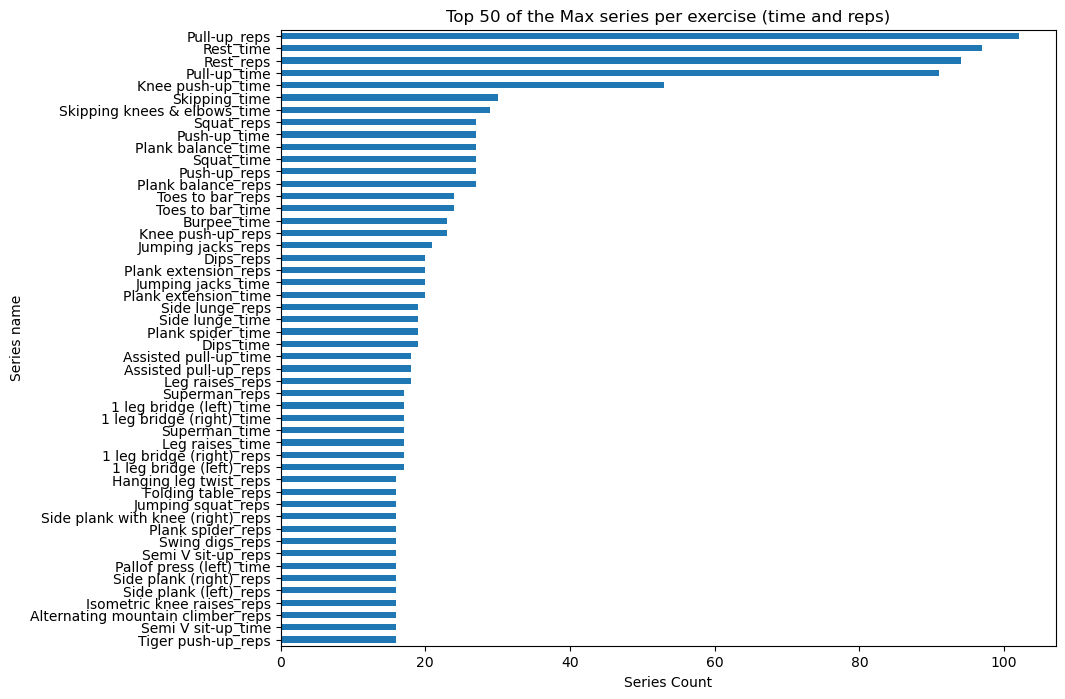

In [191]:
words_to_include = ['_time$', '_reps$']

range_reps = (0,50)
plot_conf = {
   'range_values_to_plot' : range_reps,
   'title' : 'Top ' + str(range_reps[1]) + ' of the Max series per exercise (time and reps)',
   'xlabel' : 'Series Count',
   'ylabel' : 'Series name'
}

max_new = barh_plot_of_columns(max_values, plot_conf, words_to_include)

The previous graph indicates the top 10 of the max number of series executed during a session execution per exercise. For example the **Plan balance_reps** indicates that the max number of series executed was more than 20.

### Max values of repetitions per exercise

len_max_series:  3352
Windshield wiper_reps_4           207456921.0
Weighted backward lunge_reps_2     66666666.0
Forward thrust_reps_1              54444259.0
Push-up_reps_8                      9999999.0
Squat_reps_5                        9999999.0
Name: max, dtype: float64


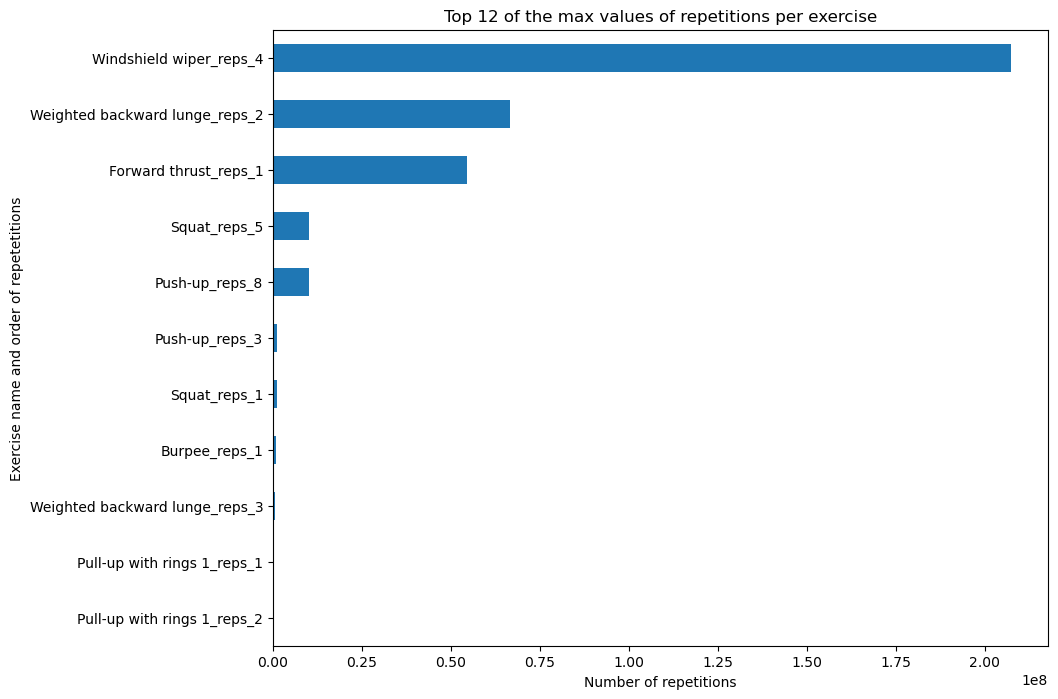

Jumping squat with weight_reps_1    2.111101e+09
Windshield wiper_reps_4             2.074569e+08
Weighted backward lunge_reps_2      6.666667e+07
Forward thrust_reps_1               5.444426e+07
Push-up_reps_8                      9.999999e+06
                                        ...     
Rest_reps_79                        1.000000e+00
Rest_reps_80                        1.000000e+00
Rest_reps_81                        1.000000e+00
Rest_reps_82                        1.000000e+00
Sit-up with weight_reps_15          1.000000e+00
Name: max, Length: 3352, dtype: float64

In [192]:
words_to_include = ['_reps_\d']

range_reps = (1,12)
plot_conf = {
   'range_values_to_plot' : range_reps,
   'title' : 'Top ' + str(range_reps[1]) + ' of the max values of repetitions per exercise',
   'xlabel' : 'Number of repetitions',
   'ylabel' : 'Exercise name and order of repetetitions'
}

barh_plot_of_columns(max_values, plot_conf, words_to_include)


### Max values of time per exercise

len_max_series:  3550
Diver_time_1                  4893.0
Pivot lunges (left)_time_2    3861.0
Rest_time_1                   3752.0
Plank balance_time_1          3719.0
Rest_time_2                   3667.0
Name: max, dtype: float64


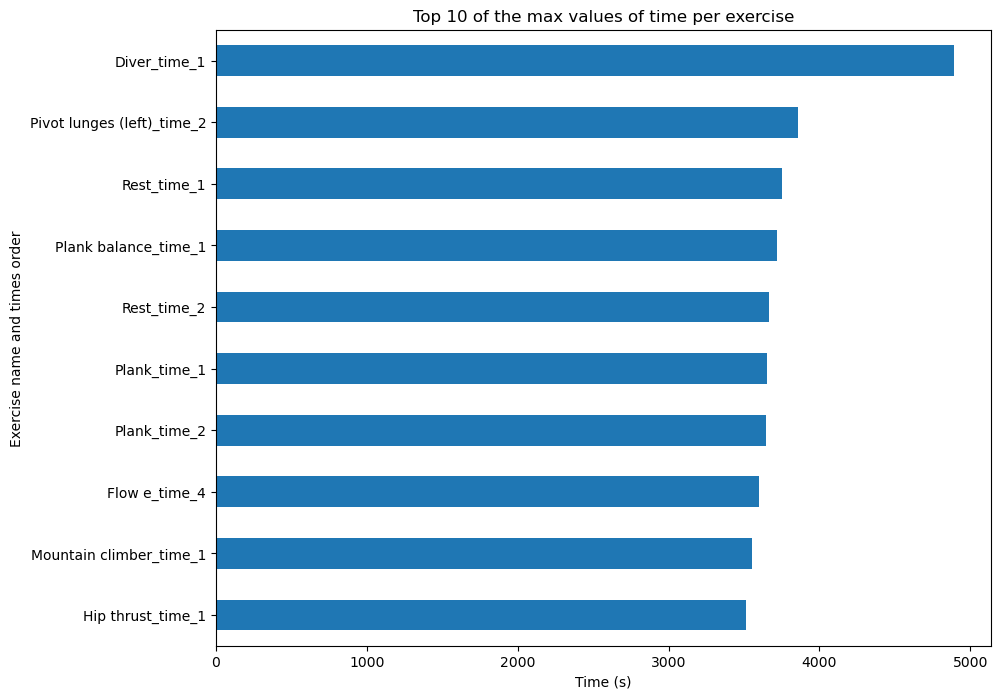

In [33]:
words_to_include= ['_time_\d']

range_reps = (0,10)
plot_conf = {
   'range_values_to_plot' : range_reps,
   'title' : 'Top ' + str(range_reps[1]) + ' of the max values of time per exercise',
   'xlabel' : 'Time (s)',
   'ylabel' : 'Exercise name and times order'
}

barh_plot_of_columns(max_values, plot_conf, words_to_include)

### Max number of the sum of repetitions per exercise

len_max_series:  430
Jumping squat with weight_sum_of_reps_per_exercise    2.111101e+09
Windshield wiper_sum_of_reps_per_exercise             2.075805e+08
Weighted backward lunge_sum_of_reps_per_exercise      6.722224e+07
Forward thrust_sum_of_reps_per_exercise               5.444426e+07
Push-up_sum_of_reps_per_exercise                      1.113099e+07
Name: max, dtype: float64


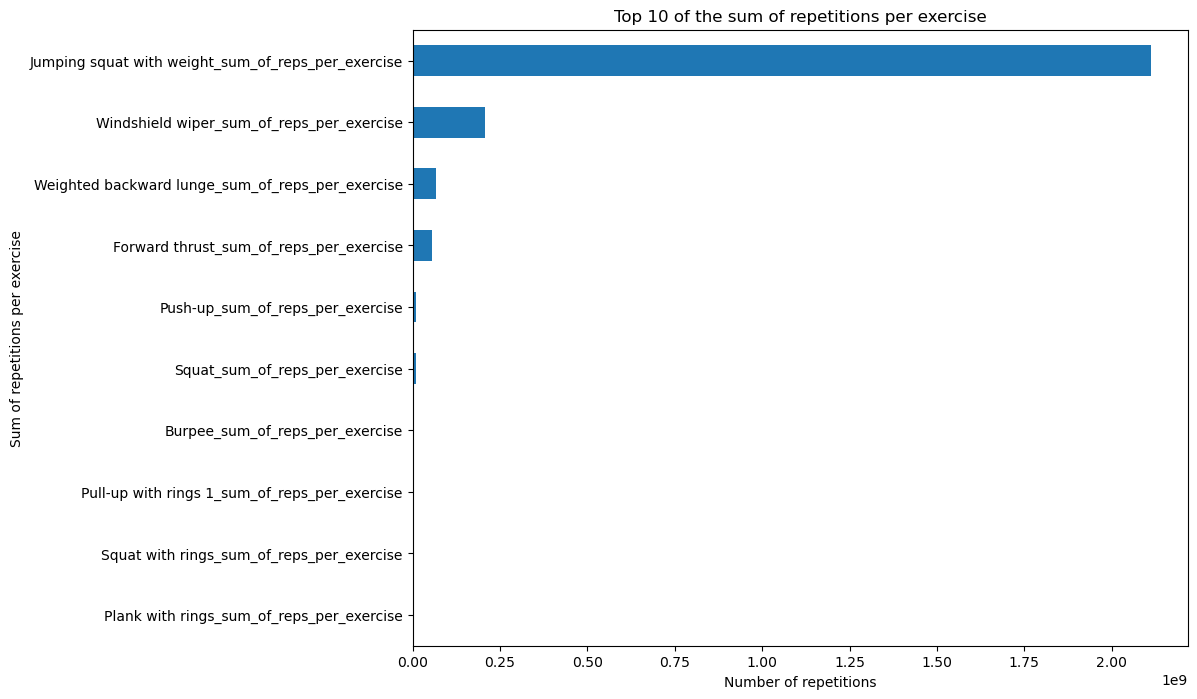

In [62]:
words_to_include = ['_sum_of_reps_per_exercise']

range_reps = (0,10)
plot_conf = {
   'range_values_to_plot' : range_reps,
   'title' : 'Top ' + str(range_reps[1]) + ' of the sum of repetitions per exercise',
   'xlabel' : 'Number of repetitions',
   'ylabel' : 'Sum of repetitions per exercise'
}

barh_plot_of_columns(max_values, plot_conf, words_to_include)

### Max number of the sum of time per exercise

len_max_series:  452
Rest_sum_of_time_per_exercise                             42736.0
Eccentric subescapular (left)_sum_of_time_per_exercise    10133.0
Leg raises_sum_of_time_per_exercise                        9284.0
Hip thrust_sum_of_time_per_exercise                        8728.0
Goblet squat_sum_of_time_per_exercise                      7879.0
Name: max, dtype: float64


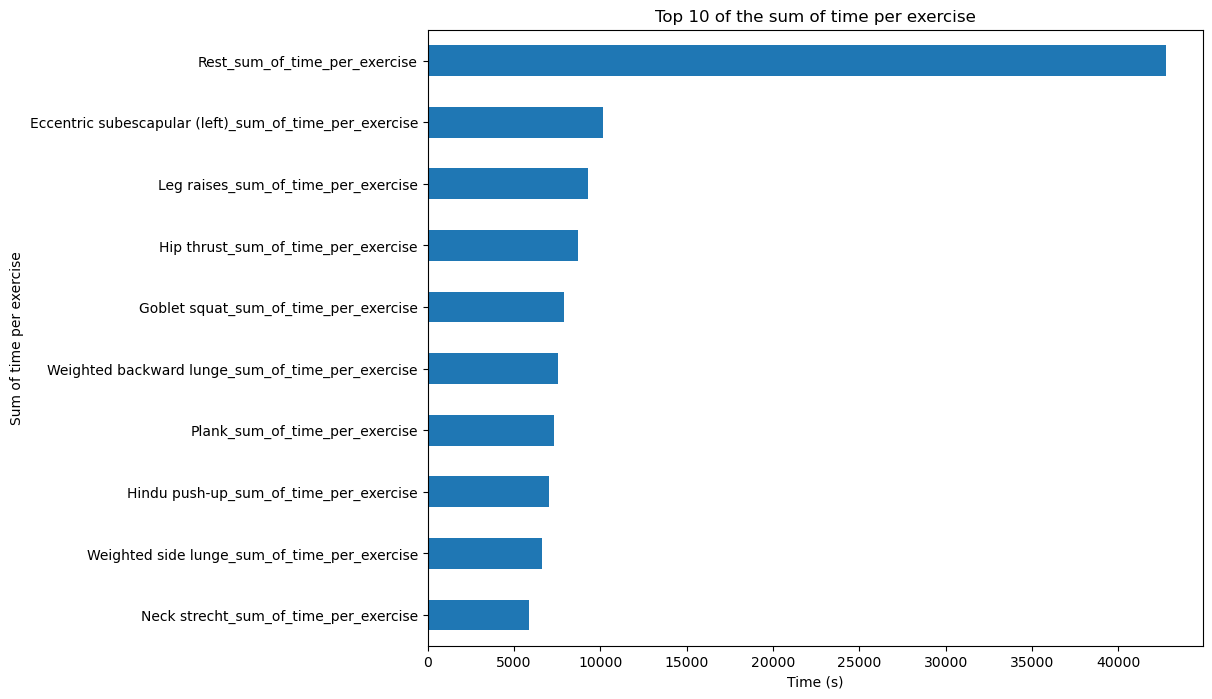

In [61]:
words_to_include = ['_sum_of_time_per_exercise']

range_reps = (0,10)
plot_conf = {
   'range_values_to_plot' : range_reps,
   'title' : 'Top ' + str(range_reps[1]) + ' of the sum of time per exercise',
   'xlabel' : 'Time (s)',
   'ylabel' : 'Sum of time per exercise'
}

barh_plot_of_columns(max_values, plot_conf, words_to_include)

## Median values

In [157]:
df_describe_zeros_excluded = df_series_recalculated.mask(df_series_recalculated==0).describe()

In [158]:
df_describe_zeros_excluded

,user_programs_user_id,1 leg bridge (left)_reps_1,1 leg bridge (left)_reps_10,1 leg bridge (left)_reps_11,1 leg bridge (left)_reps_12,1 leg bridge (left)_reps_13,1 leg bridge (left)_reps_14,1 leg bridge (left)_reps_15,1 leg bridge (left)_reps_16,1 leg bridge (left)_reps_17,1 leg bridge (left)_reps_2,1 leg bridge (left)_reps_3,1 leg bridge (left)_reps_4,1 leg bridge (left)_reps_5,1 leg bridge (left)_reps_6,1 leg bridge (left)_reps_7,1 leg bridge (left)_reps_8,1 leg bridge (left)_reps_9,1 leg bridge (left)_time_1,1 leg bridge (left)_time_10,1 leg bridge (left)_time_11,1 leg bridge (left)_time_12,1 leg bridge (left)_time_13,1 leg bridge (left)_time_14,1 leg bridge (left)_time_15,1 leg bridge (left)_time_16,1 leg bridge (left)_time_17,1 leg bridge (left)_time_2,1 leg bridge (left)_time_3,1 leg bridge (left)_time_4,1 leg bridge (left)_time_5,1 leg bridge (left)_time_6,1 leg bridge (left)_time_7,1 leg bridge (left)_time_8,1 leg bridge (left)_time_9,1 leg bridge (right)_reps_1,1 leg bridge (right)_reps_10,1 leg bridge (right)_reps_11,1 leg bridge (right)_reps_12,1 leg bridge (right)_reps_13,1 leg bridge (right)_reps_14,1 leg bridge (right)_reps_15,1 leg bridge (right)_reps_16,1 leg bridge (right)_reps_17,1 leg bridge (right)_reps_2,1 leg bridge (right)_reps_3,1 leg bridge (right)_reps_4,1 leg bridge (right)_reps_5,1 leg bridge (right)_reps_6,1 leg bridge (right)_reps_7,1 leg bridge (right)_reps_8,1 leg bridge (right)_reps_9,1 leg bridge (right)_time_1,1 leg bridge (right)_time_10,1 leg bridge (right)_time_11,1 leg bridge (right)_time_12,1 leg bridge (right)_time_13,1 leg bridge (right)_time_14,1 leg bridge (right)_time_15,1 leg bridge (right)_time_16,1 leg bridge (right)_time_17,1 leg bridge (right)_time_2,1 leg bridge (right)_time_3,1 leg bridge (right)_time_4,1 leg bridge (right)_time_5,1 leg bridge (right)_time_6,1 leg bridge (right)_time_7,1 leg bridge (right)_time_8,1 leg bridge (right)_time_9,1 leg dead lift (left)_reps_1,1 leg dead lift (left)_reps_10,1 leg dead lift (left)_reps_11,1 leg dead lift (left)_reps_12,1 leg dead lift (left)_reps_13,1 leg dead lift (left)_reps_14,1 leg dead lift (left)_reps_15,1 leg dead lift (left)_reps_2,1 leg dead lift (left)_reps_3,1 leg dead lift (left)_reps_4,1 leg dead lift (left)_reps_5,1 leg dead lift (left)_reps_6,1 leg dead lift (left)_reps_7,1 leg dead lift (left)_reps_8,1 leg dead lift (left)_reps_9,1 leg dead lift (left)_time_1,1 leg dead lift (left)_time_10,1 leg dead lift (left)_time_11,1 leg dead lift (left)_time_12,1 leg dead lift (left)_time_13,1 leg dead lift (left)_time_14,1 leg dead lift (left)_time_15,1 leg dead lift (left)_time_2,1 leg dead lift (left)_time_3,1 leg dead lift (left)_time_4,1 leg dead lift (left)_time_5,1 leg dead lift (left)_time_6,1 leg dead lift (left)_time_7,1 leg dead lift (left)_time_8,1 leg dead lift (left)_time_9,1 leg dead lift (right)_reps_1,1 leg dead lift (right)_reps_10,1 leg dead lift (right)_reps_11,1 leg dead lift (right)_reps_12,1 leg dead lift (right)_reps_13,1 leg dead lift (right)_reps_14,1 leg dead lift (right)_reps_15,1 leg dead lift (right)_reps_2,1 leg dead lift (right)_reps_3,1 leg dead lift (right)_reps_4,1 leg dead lift (right)_reps_5,1 leg dead lift (right)_reps_6,1 leg dead lift (right)_reps_7,1 leg dead lift (right)_reps_8,1 leg dead lift (right)_reps_9,1 leg dead lift (right)_time_1,1 leg dead lift (right)_time_10,1 leg dead lift (right)_time_11,1 leg dead lift (right)_time_12,1 leg dead lift (right)_time_13,1 leg dead lift (right)_time_14,1 leg dead lift (right)_time_15,1 leg dead lift (right)_time_2,1 leg dead lift (right)_time_3,1 leg dead lift (right)_time_4,1 leg dead lift (right)_time_5,1 leg dead lift (right)_time_6,1 leg dead lift (right)_time_7,1 leg dead lift (right)_time_8,1 leg dead lift (right)_time_9,1 leg dead lift 1with KB (right)_reps_1,1 leg dead lift 1with KB (right)_reps_10,1 leg dead lift 1with KB (right)_reps_11,1 leg dead lift 1with KB (right)_reps_12,1 leg dead lift 1with KB (right)_reps_13,1 leg dead lift 1

In [41]:
def get_median(df):
    
    # Drop the columns that we do not want to be included in the graph
    df = df.drop(columns=columns_to_remove)

    # Get the median od columns
    median_zeros_excluded = df.loc['50%', :].sort_values(ascending = False)

    return median_zeros_excluded

median_zeros_excluded = get_median(df_describe_zeros_excluded)

### Median values of the series executed (time and reps)

#### Top 10 values

len_max_series:  882
Rest_time                     13.0
Farmer's walk (left)_reps     12.0
Isometric knee raises_reps    12.0
Farmer's walk (right)_reps    12.0
Isometric knee raises_time    12.0
Name: 50%, dtype: float64


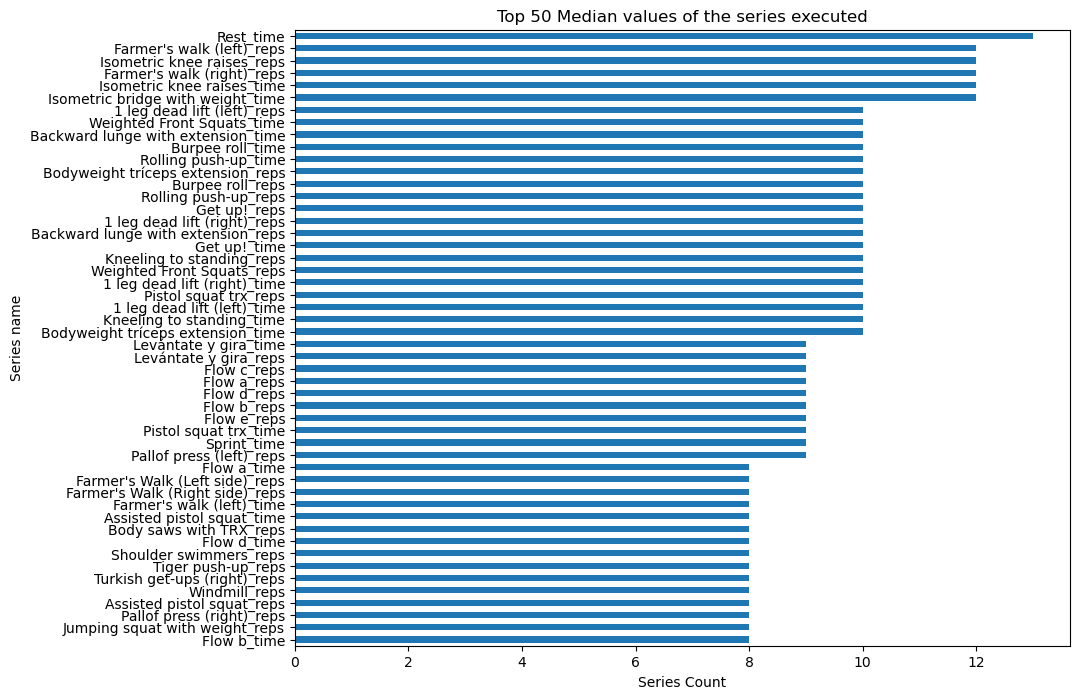

len_max_series:  882
Assisted squat_time                 1.0
Assisted push-up_time               1.0
Spiderman_time                      1.0
Quadruped Superman_time             1.0
Plank hand to opposite foot_time    1.0
Name: 50%, dtype: float64


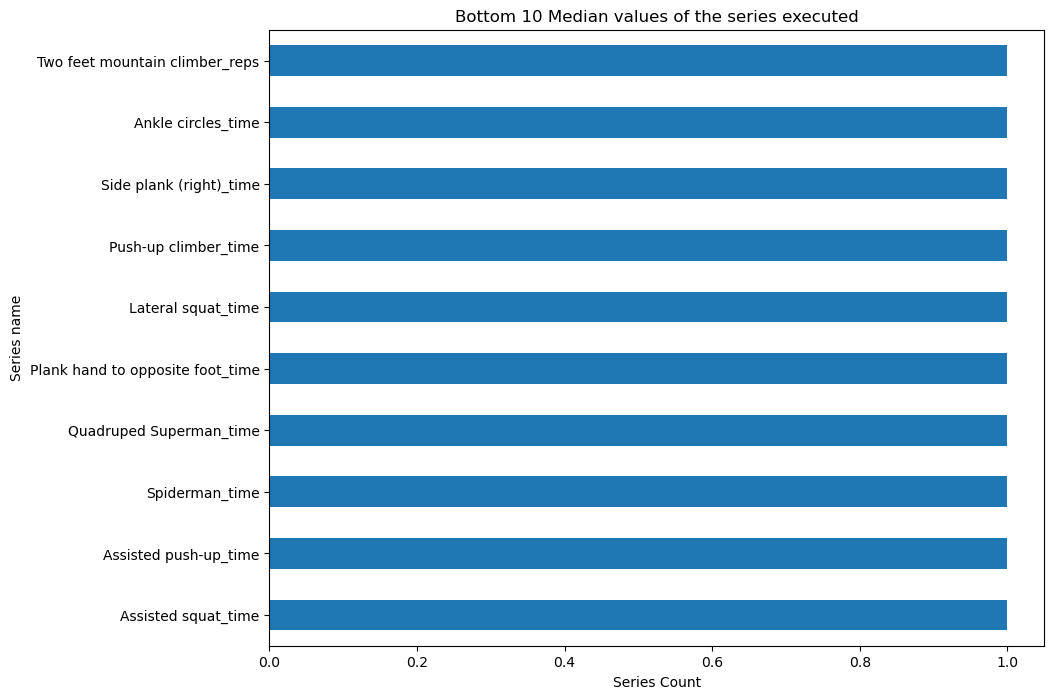

In [56]:
# Top 10 values
words_to_include = ['_time$', '_reps$']

range_values = (0,50)

plot_conf = {
   'range_values_to_plot' : range_values,
   'title' : 'Top ' + str(range_values[1]) + ' Median values of the series executed',
   'xlabel' : 'Series Count',
   'ylabel' : 'Series name'
}

barh_plot_of_columns(median_zeros_excluded, plot_conf, words_to_include, ascending = True)

# Bottom 10 values
words_to_include = ['_time$', '_reps$']

range_values = (872,882)

plot_conf = {
   'range_values_to_plot' : range_values,
   'title' : 'Bottom ' + str(range_values[1] - range_values[0]) + ' Median values of the series executed',
   'xlabel' : 'Series Count',
   'ylabel' : 'Series name'
}

barh_plot_of_columns(median_zeros_excluded, plot_conf, words_to_include)

### Median values of repetitions per exercise

len_max_series:  3352
Jump rope_reps_2    100.0
Jump rope_reps_6    100.0
Jump rope_reps_1    100.0
Jump rope_reps_3    100.0
Jump rope_reps_5    100.0
Name: 50%, dtype: float64


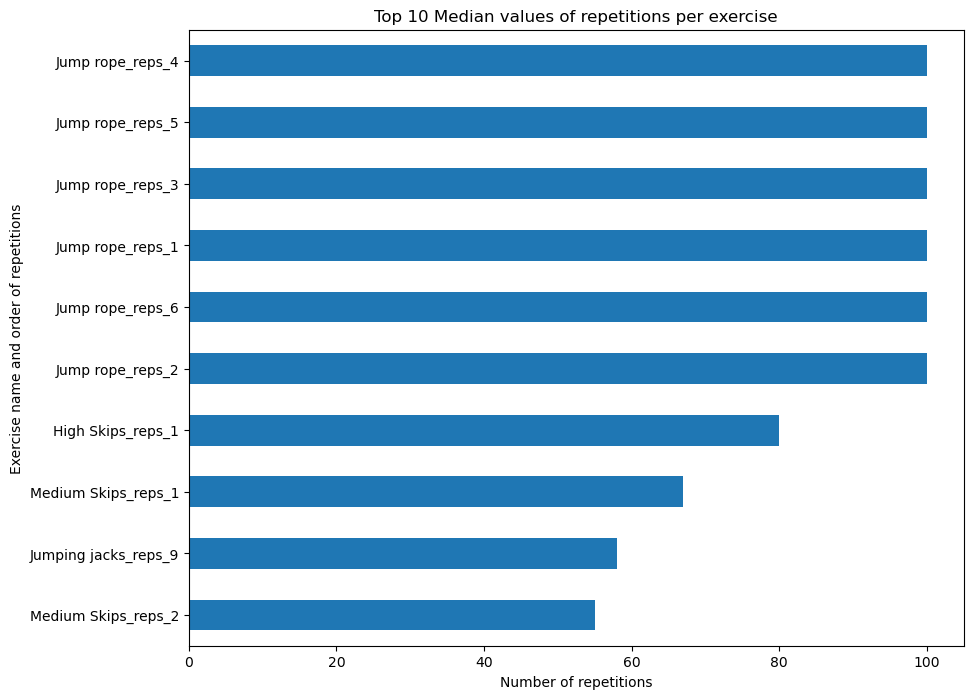

len_max_series:  3352
Rest_reps_60    1.0
Rest_reps_6     1.0
Rest_reps_53    1.0
Rest_reps_18    1.0
Rest_reps_54    1.0
Name: 50%, dtype: float64


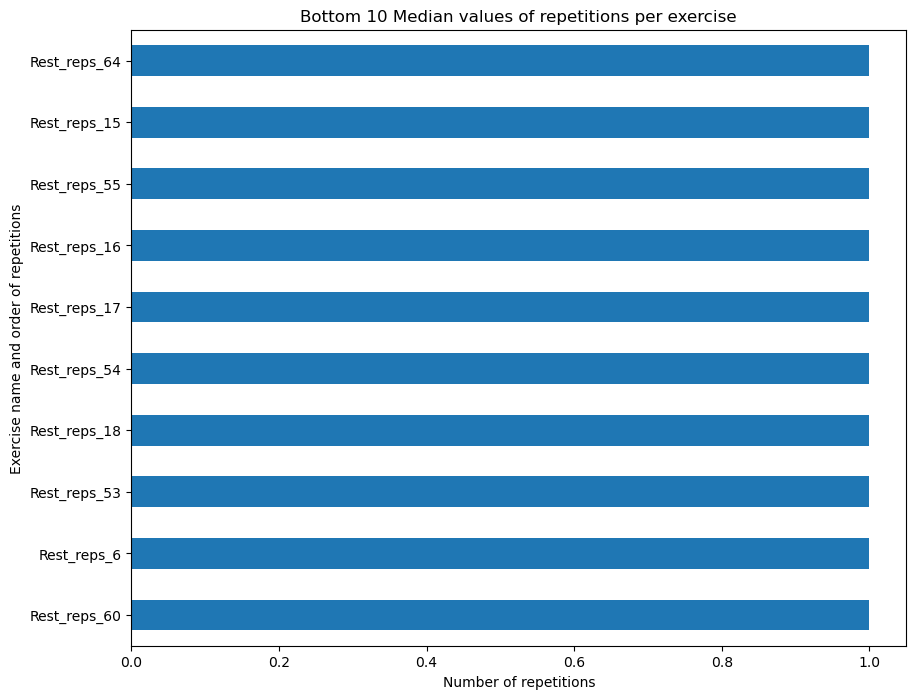

In [57]:
#### Top 10 values

words_to_include = ['_reps_\d']

range_values = (0,10)
plot_conf = {
   'range_values_to_plot' : range_values,
   'title' : 'Top ' + str(range_values[1]) + ' Median values of repetitions per exercise',
   'xlabel' : 'Number of repetitions',
   'ylabel' : 'Exercise name and order of repetitions'
}

barh_plot_of_columns(median_zeros_excluded, plot_conf, words_to_include)

#### Bottom 10 values

words_to_include = ['_reps_\d']

range_values = (3342,3352)
plot_conf = {
   'range_values_to_plot' : range_values,
   'title' : 'Bottom ' + str(range_values[1] - range_values[0]) + ' Median values of repetitions per exercise',
   'xlabel' : 'Number of repetitions',
   'ylabel' : 'Exercise name and order of repetitions'
}

barh_plot_of_columns(median_zeros_excluded, plot_conf, words_to_include)

### Median values of time per exercise


len_max_series:  3550
Windmill with weight (right)_time_5        477.0
Jumping lunge_time_15                      419.0
Walk_time_1                                363.5
Tuck hold to tuck shoulder stand_time_1    338.0
Muscle-up 2_time_1                         303.0
Name: 50%, dtype: float64


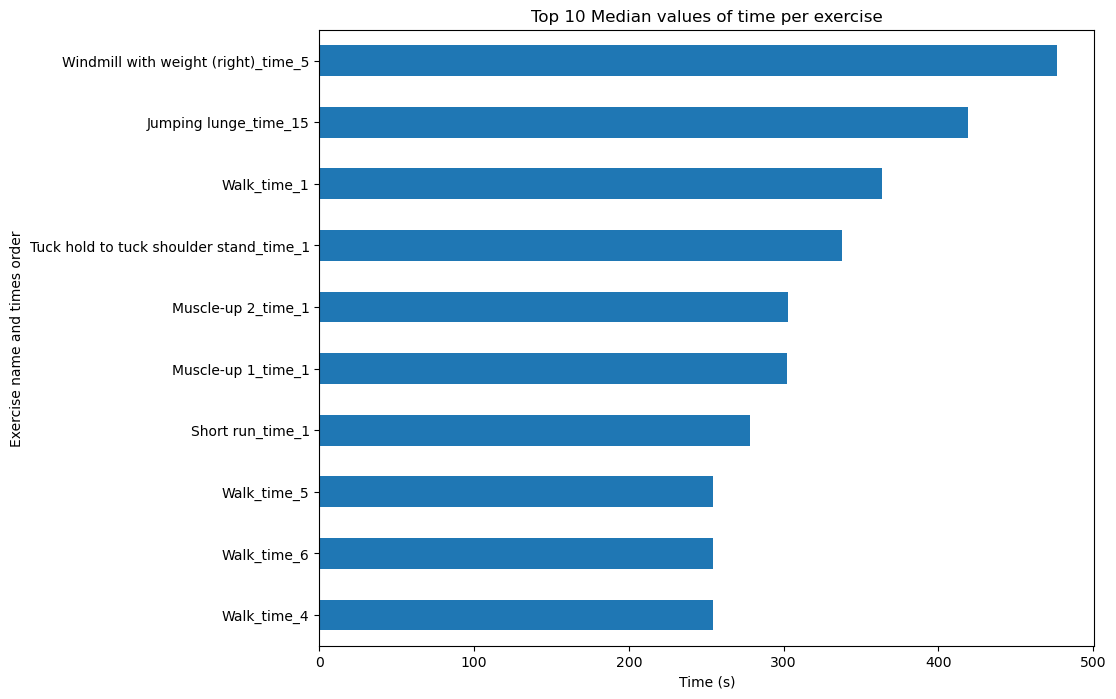

len_max_series:  3550
Vertical ring push-up 2_time_7      1.0
Pull-up_time_62                     1.0
Rocket with weight (left)_time_9    1.0
Pull-up_time_71                     1.0
Pull-up_time_72                     1.0
Name: 50%, dtype: float64


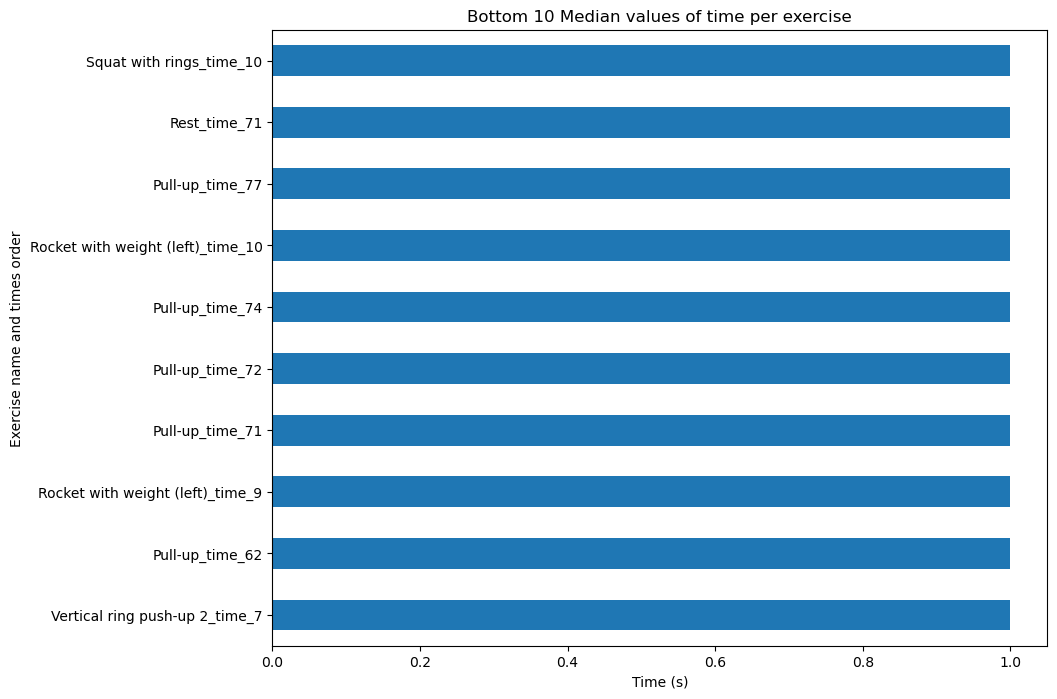

In [58]:
# Top 10 values

words_to_include= ['_time_\d']

range_values = (0,10)
plot_conf = {
   'range_values_to_plot' : range_values,
   'title' : 'Top ' + str(range_values[1]) + ' Median values of time per exercise',
   'xlabel' : 'Time (s)',
   'ylabel' : 'Exercise name and times order'
}

barh_plot_of_columns(median_zeros_excluded, plot_conf, words_to_include)

# Bottom 10 values

words_to_include= ['_time_\d']

range_values = (3540,3550)
plot_conf = {
   'range_values_to_plot' : range_values,
   'title' : 'Bottom ' + str(range_values[1] - range_values[0]) + ' Median values of time per exercise',
   'xlabel' : 'Time (s)',
   'ylabel' : 'Exercise name and times order'
}

barh_plot_of_columns(median_zeros_excluded, plot_conf, words_to_include)

### Median values of the sum of repetitions per exercise

len_max_series:  430
Jump rope_sum_of_reps_per_exercise                400.0
Farmer's walk (left)_sum_of_reps_per_exercise     286.0
Farmer's walk (right)_sum_of_reps_per_exercise    258.0
Shoulder swimmers_sum_of_reps_per_exercise        240.0
Lunge with turns_sum_of_reps_per_exercise         202.0
Name: 50%, dtype: float64


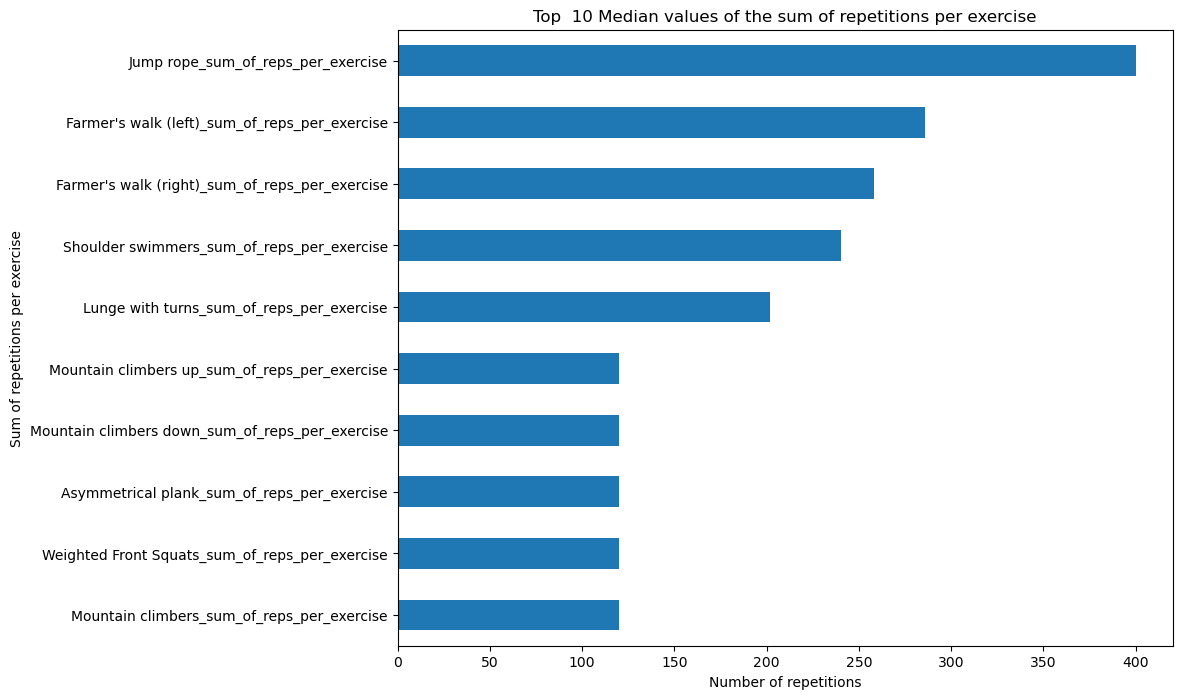

len_max_series:  430
Rest_sum_of_reps_per_exercise                         8.0
Thoracic rotations (left)_sum_of_reps_per_exercise    8.0
Turkish get-ups (right)_sum_of_reps_per_exercise      8.0
Turkish get-ups (left)_sum_of_reps_per_exercise       8.0
Kneeling squat_sum_of_reps_per_exercise               8.0
Name: 50%, dtype: float64


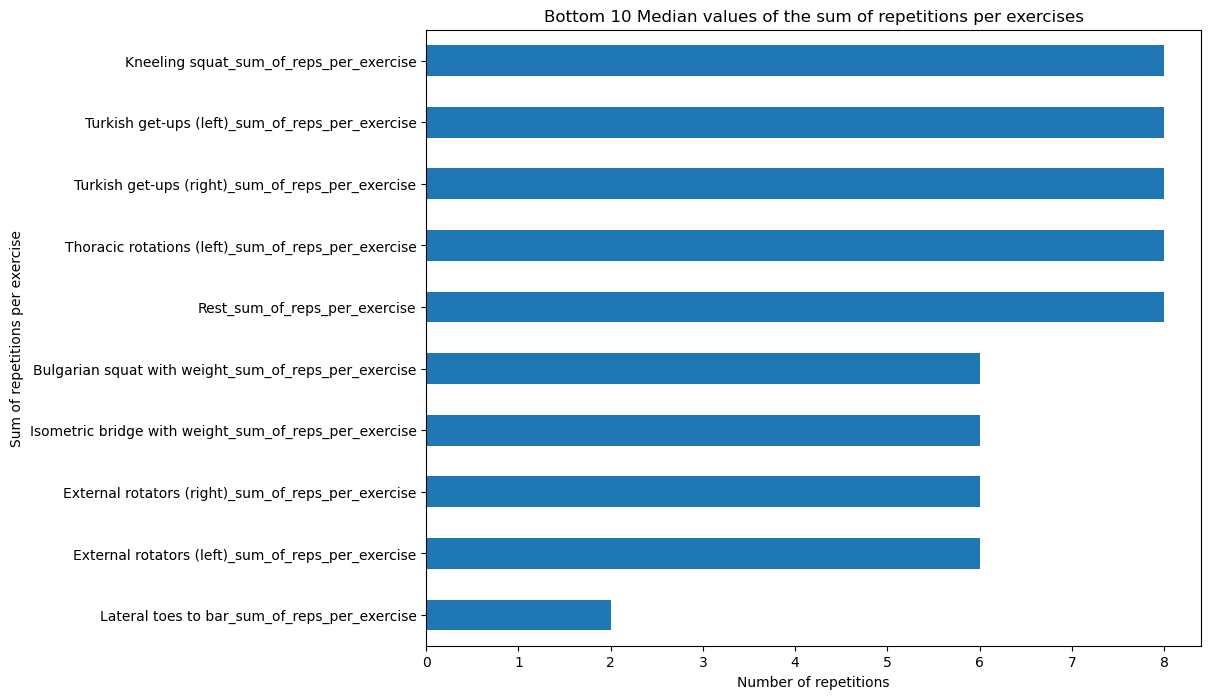

In [59]:
# Top 10 values

words_to_include = ['_sum_of_reps_per_exercise']

range_reps = (0,10)
plot_conf = {
   'range_values_to_plot' : range_reps,
   'title' : 'Top  ' + str(range_reps[1]) + ' Median values of the sum of repetitions per exercise',
   'xlabel' : 'Number of repetitions',
   'ylabel' : 'Sum of repetitions per exercise'
}
barh_plot_of_columns(median_zeros_excluded, plot_conf, words_to_include)

# Bottom 10 values
words_to_include = ['_sum_of_reps_per_exercise']

range_reps = (420,430)
plot_conf = {
   'range_values_to_plot' : range_reps,
   'title' : 'Bottom ' + str(range_values[1] - range_values[0]) + ' Median values of the sum of repetitions per exercise',
   'xlabel' : 'Number of repetitions',
   'ylabel' : 'Sum of repetitions per exercise'
}
barh_plot_of_columns(median_zeros_excluded, plot_conf, words_to_include)

### Median values of the sum of time per exercise

len_max_series:  452
Walk_sum_of_time_per_exercise                1207.0
Short run_sum_of_time_per_exercise            948.0
Rolling push-up_sum_of_time_per_exercise      659.0
Skipping_sum_of_time_per_exercise             479.0
Lunge with turns_sum_of_time_per_exercise     473.0
Name: 50%, dtype: float64


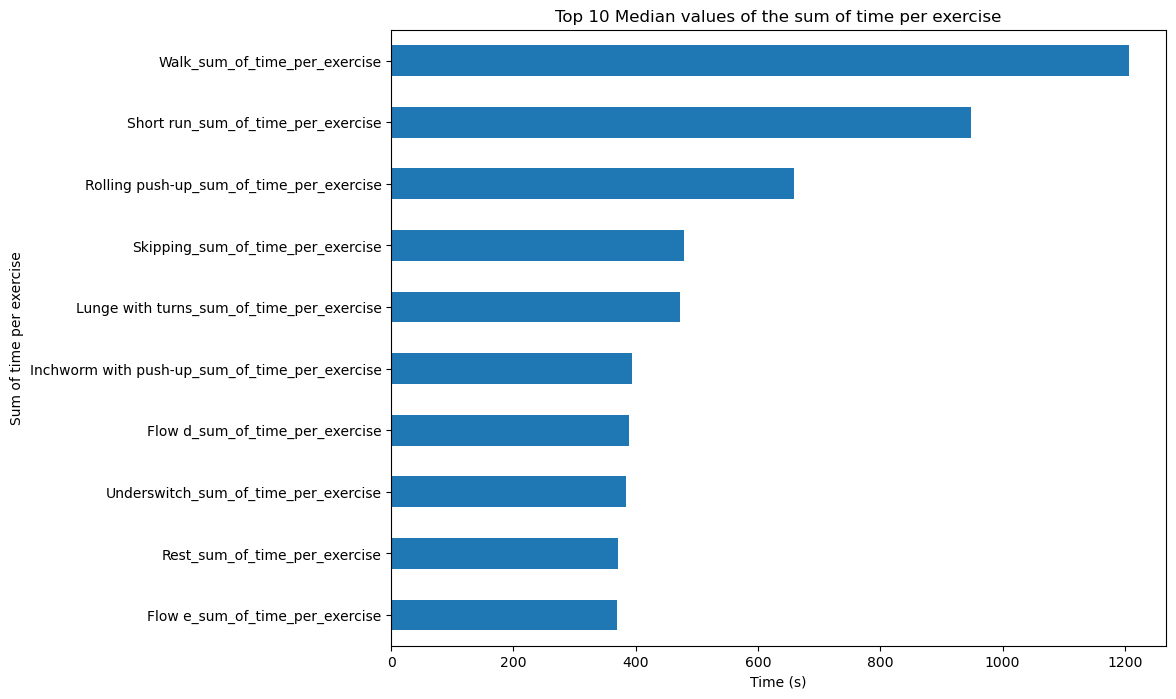

len_max_series:  452
Windmill with weight (left)_sum_of_time_per_exercise      13.5
Thruster with KB (left)_sum_of_time_per_exercise          12.0
Assisted pistol squat (left)_sum_of_time_per_exercise     11.0
Unilateral transport (left)_sum_of_time_per_exercise      10.0
Thruster with kettlebell left_sum_of_time_per_exercise     8.0
Name: 50%, dtype: float64


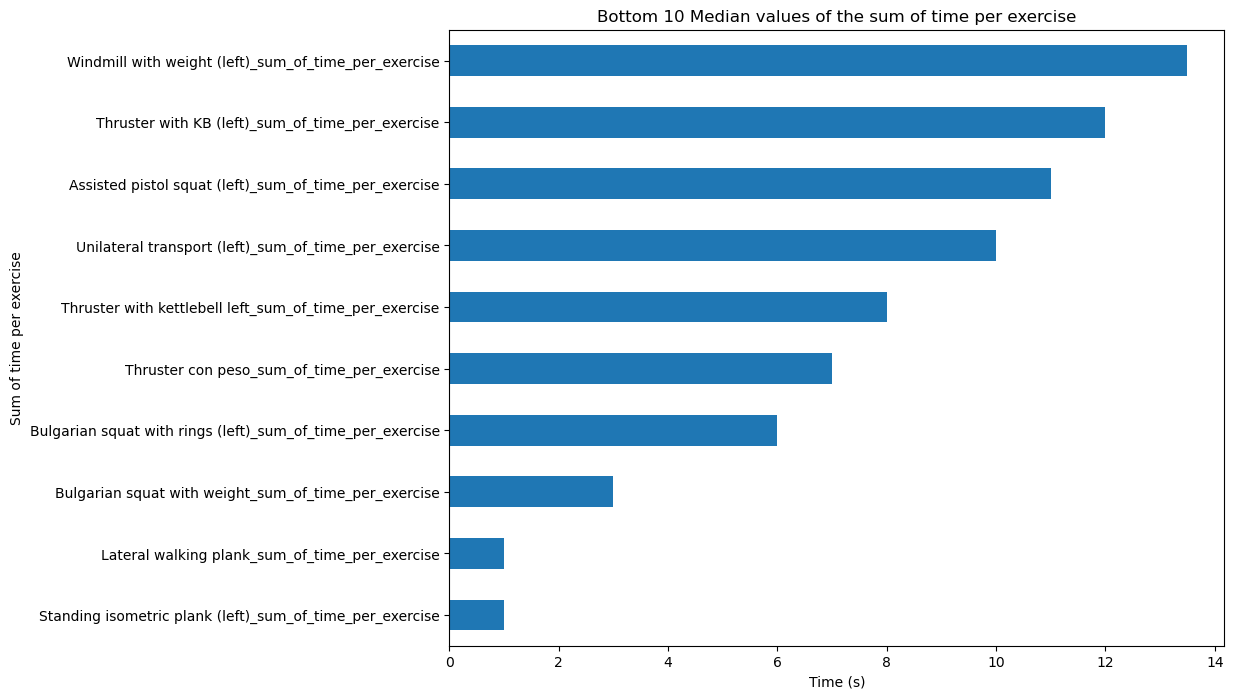

In [60]:
# Top 10 values
words_to_include = ['_sum_of_time_per_exercise']

range_reps = (0,10)
plot_conf = {
   'range_values_to_plot' : range_reps,
   'title' : 'Top ' + str(range_reps[1]) + ' Median values of the sum of time per exercise',
   'xlabel' : 'Time (s)',
   'ylabel' : 'Sum of time per exercise'
}

barh_plot_of_columns(median_zeros_excluded, plot_conf, words_to_include)

# Bottom 10 values
words_to_include = ['_sum_of_time_per_exercise']

range_reps = (442,452)
plot_conf = {
   'range_values_to_plot' : range_reps,
   'title' : 'Bottom ' + str(range_values[1] - range_values[0]) + ' Median values of the sum of time per exercise',
   'xlabel' : 'Time (s)',
   'ylabel' : 'Sum of time per exercise'
}

barh_plot_of_columns(median_zeros_excluded, plot_conf, words_to_include)

## Max and Median of cummulative values

In [65]:
df_describe_commulative_values = df_describe_zeros_excluded.loc[:,columns_to_remove].drop(columns=['user_programs_user_id'])

In [68]:
df_describe_commulative_values.reset_index(inplace=True)

In [70]:
describe_num_df = df_describe_commulative_values[df_describe_commulative_values['index'] != 'count']

In [71]:
describe_num_df

,index,total_count_of_time,total_count_of_reps,sum_of_reps,sum_of_time,session_executions_summary_effort,session_executions_summary_points,session_executions_summary_total_kcal,session_executions_summary_value_of_session
1,mean,37.723285,25.249727,5.556934e+04,1328.321896,6.109858,106.245670,130.057477,3.884729
2,std,19.652371,14.030419,9.928625e+06,906.775313,2.494777,33.966978,228.152118,1.443010
3,min,1.000000,1.000000,1.000000e+00,2.000000,1.000000,50.000000,1.000000,1.000000
4,25%,25.000000,17.000000,1.510000e+02,856.000000,5.000000,100.000000,72.000000,3.000000
5,50%,35.000000,23.000000,2.400000e+02,1293.000000,5.000000,100.000000,104.000000,4.000000
6,75%,46.000000,31.000000,3.300000e+02,1682.000000,7.000000,100.000000,150.000000,4.000000
7,max,260.000000,239.000000,2.111101e+09,80587.000000,136.000000,2300.000000,12164.000000,74.000000


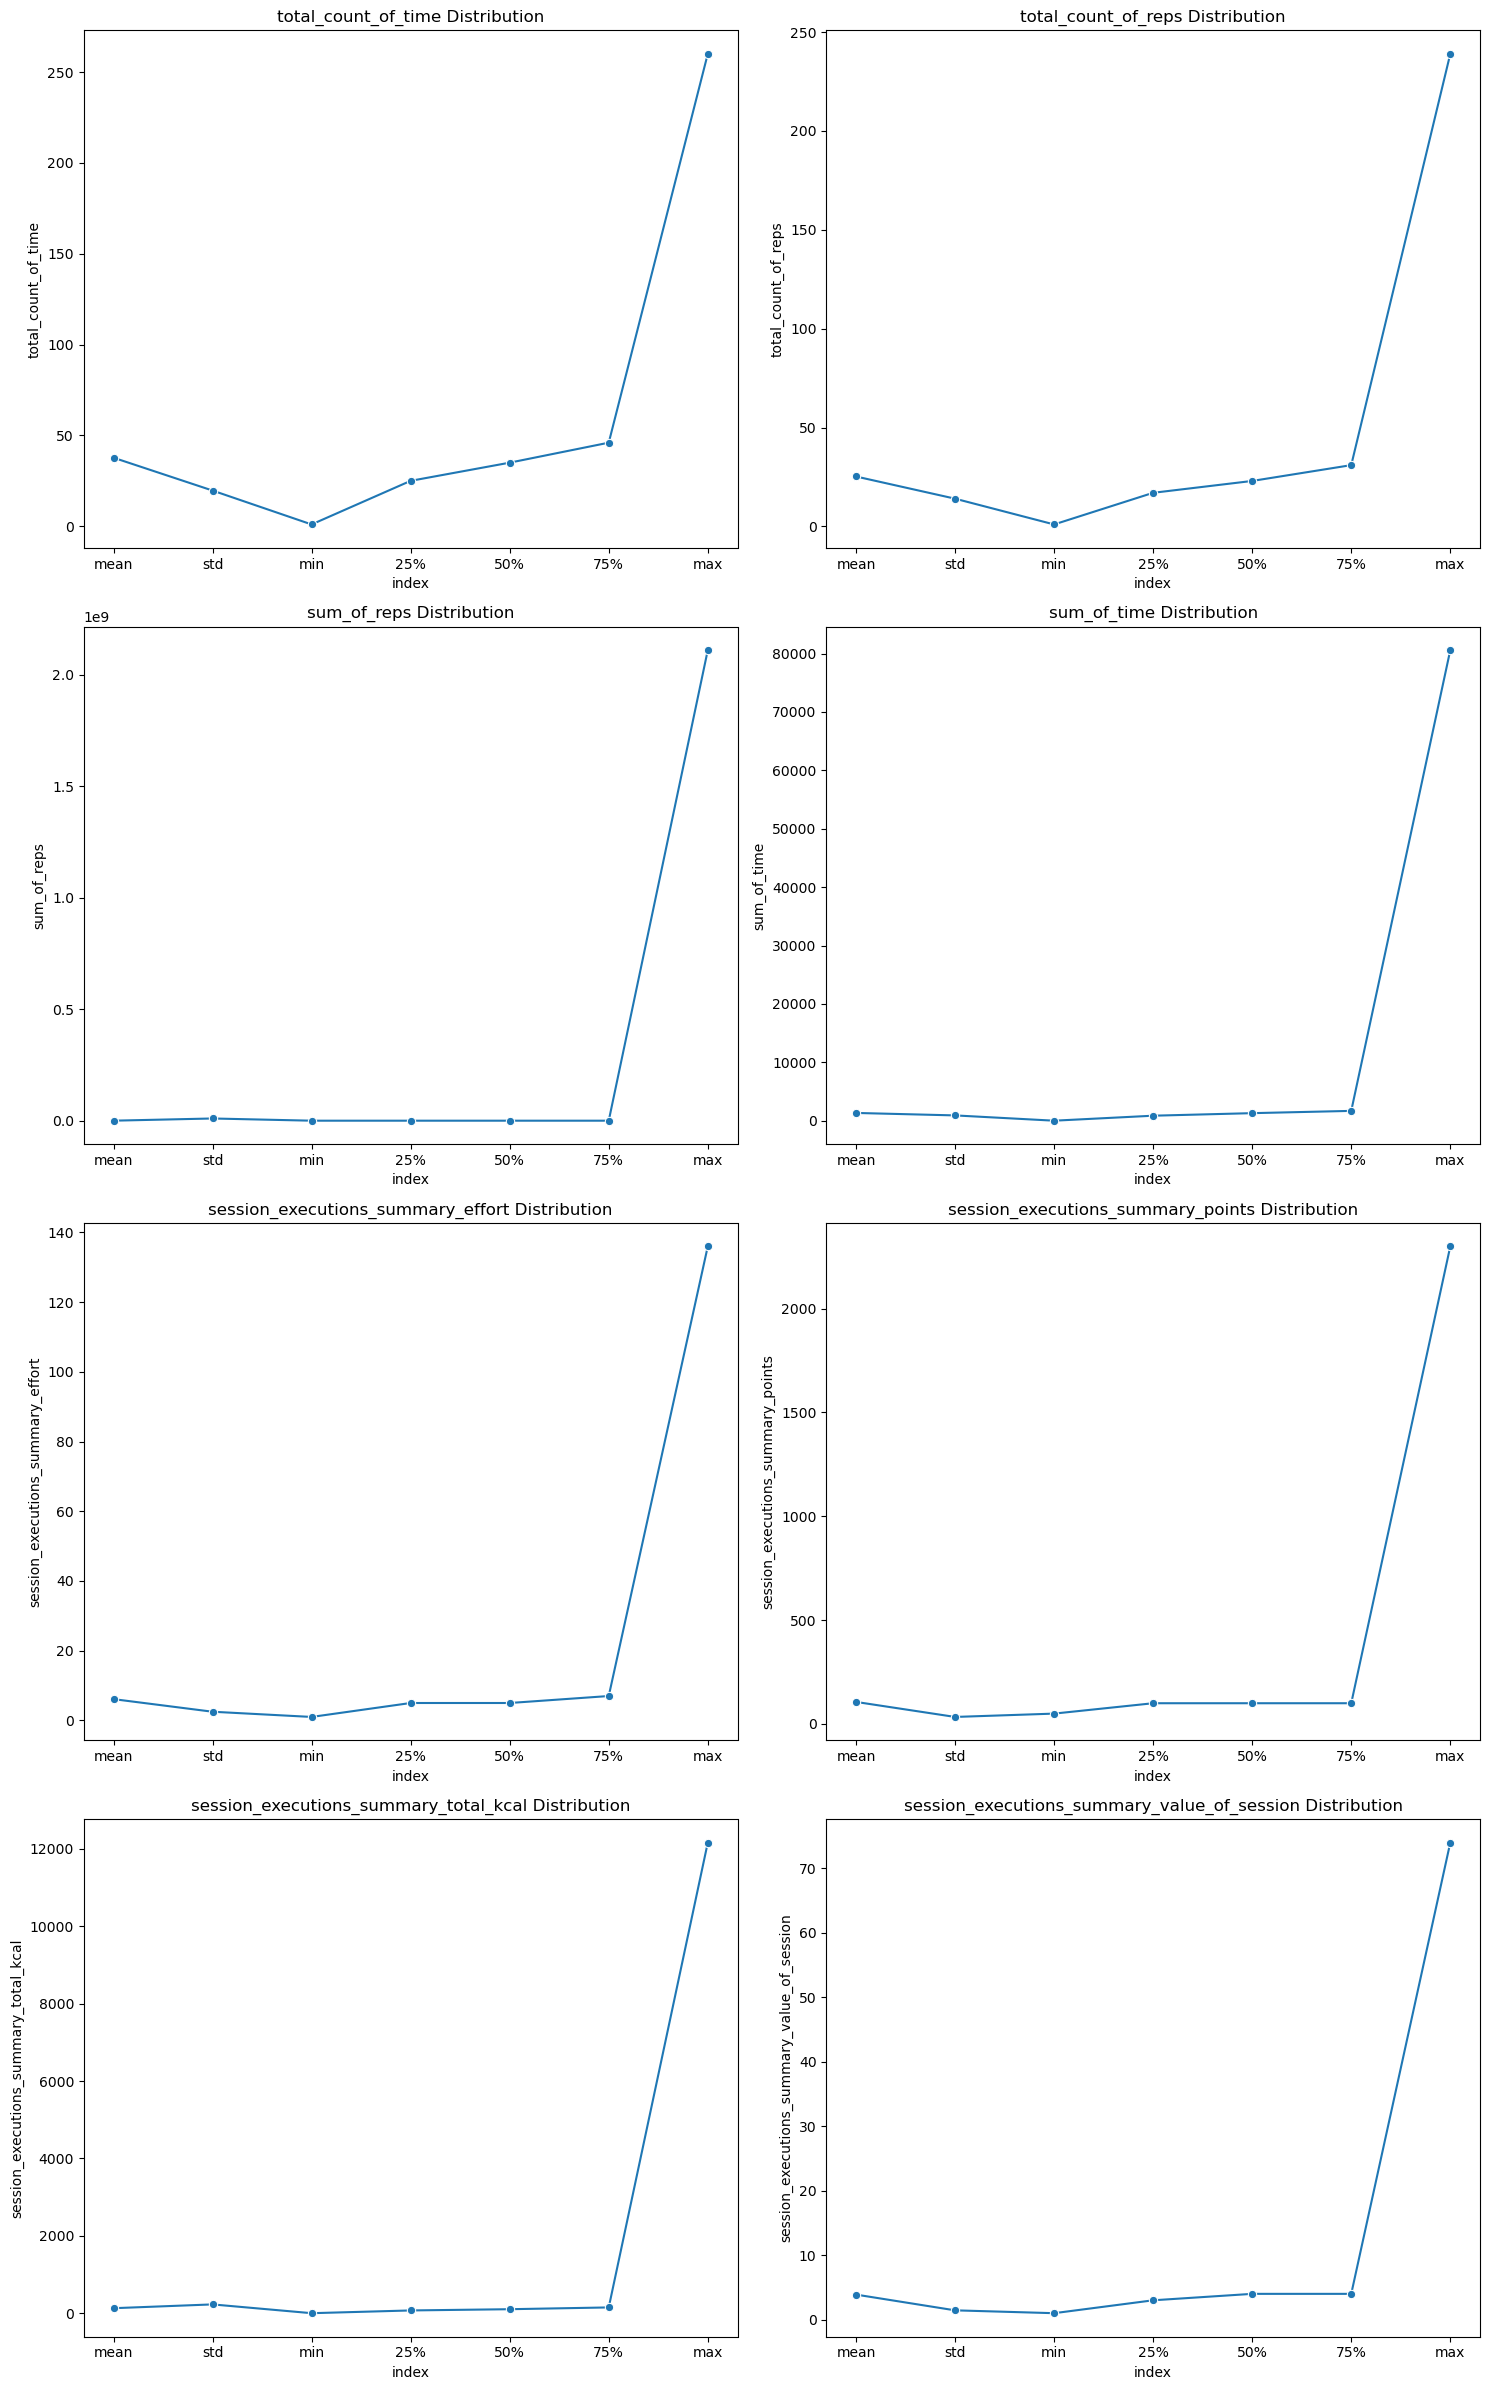

In [107]:
num_cols = len(describe_num_df.columns) - 1  # Exclude the 'index' column
num_rows = (num_cols + 1) // 2  # Calculate the number of rows needed
fig, axes = plt.subplots(nrows=num_rows, ncols=2, figsize=(15, 6*num_rows))

# Plot each numerical column as a subplot
row_plot = 0
col_plot = 0

for idx, col in enumerate(describe_num_df.columns):
    idx = idx - 1
    if col == 'index':
        continue  

    sns.lineplot(x='index', y=col, data=describe_num_df, ax=axes[row_plot,col_plot], marker="o")
    axes[row_plot,col_plot].set_title(f'{col} Distribution')

    if idx%2 ==0:
       col_plot = col_plot + 1
    else:
       row_plot = row_plot + 1
       col_plot = 0 

# Adjust layout to prevent overlapping
plt.tight_layout()

### Sum of Reps

C:\Users\eVida-PC\AppData\Local\Temp\ipykernel_27120\3826346831.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_sum_of_reps = top_sum_of_reps[range_max[0]:range_max[1]]


Text(0, 0.5, 'Index of sessions')

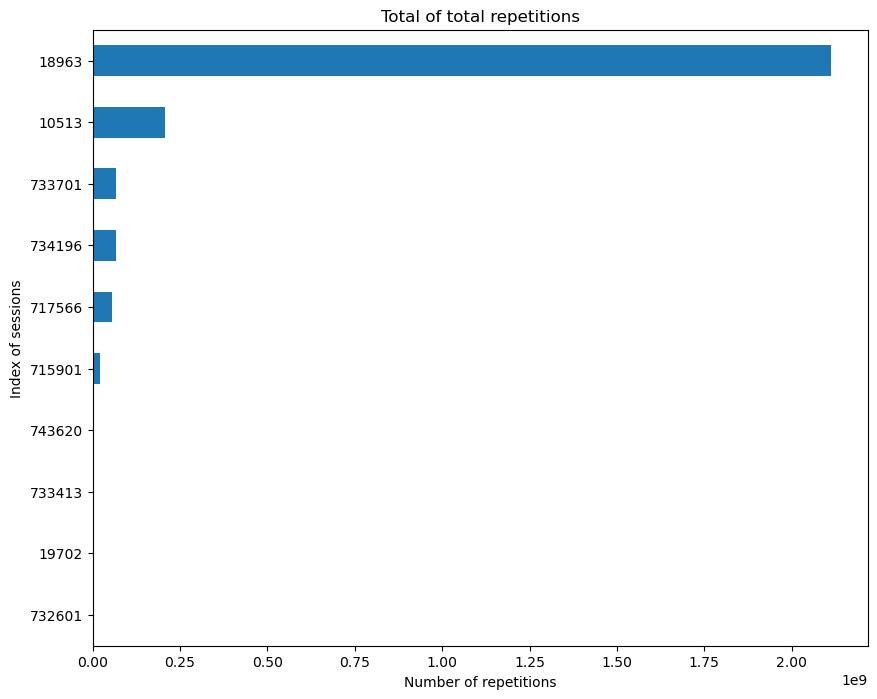

In [36]:
range_max = (0,10)
top_sum_of_reps = df_series_recalculated['sum_of_reps'].sort_values(ascending=False)
top_sum_of_reps = top_sum_of_reps[range_max[0]:range_max[1]]
# Sorting and plotting
ax_reps = top_sum_of_reps.sort_values(ascending=True).plot(kind='barh', figsize=(10, 8))

# Set title and labels
ax_reps.set_title('Total of total repetitions')
ax_reps.set_xlabel('Number of repetitions')
ax_reps.set_ylabel('Index of sessions')

### Total Time

C:\Users\eVida-PC\AppData\Local\Temp\ipykernel_27120\2973615948.py:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  top_sum_of_time = top_sum_of_time[range_max[0]:range_max[1]]


Text(0, 0.5, 'Index of sessions')

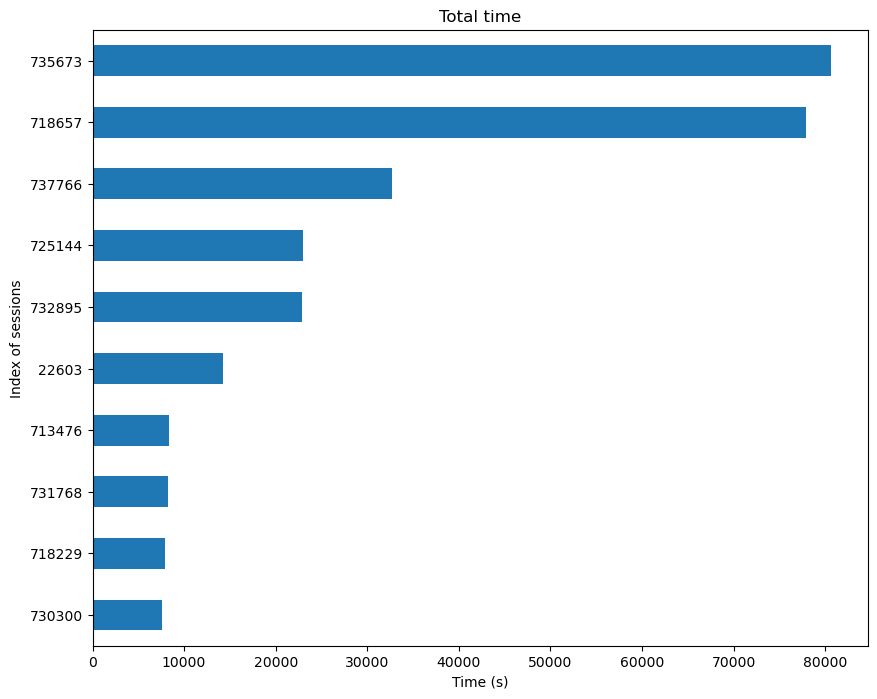

In [37]:
range_max = (0,10)
top_sum_of_time = df_series_recalculated['sum_of_time'].sort_values(ascending=False)
top_sum_of_time = top_sum_of_time[range_max[0]:range_max[1]]

# Sorting and plotting
ax = top_sum_of_time.sort_values(ascending=True).plot(kind='barh', figsize=(10, 8))

# Set title and labels
ax.set_title('Total time')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Index of sessions')